In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import os
import random
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

In [10]:
def showImages(idxs, image_files=None, images=None):
    plt.figure(figsize=(20, 10))
    if image_files is not None:
        for i, idx in enumerate(idxs):
            img = cv2.imread(image_files[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Ảnh {i+1}")
    elif images is not None:
        for i in range(len(idxs)):
            plt.subplot(1, 5, i + 1)
            plt.imshow(images[i], cmap='gray')  # Hiển thị ảnh xám
            plt.axis('off')
            plt.title(f"Ảnh {i+1}")
    else:
        raise ValueError("Cần cung cấp ít nhất một trong hai tham số: image_files hoặc images")

    plt.show()

1. Tiền xử lý dữ liệu

Số lượng ảnh đã chọn: 4
Các ảnh đã chọn:


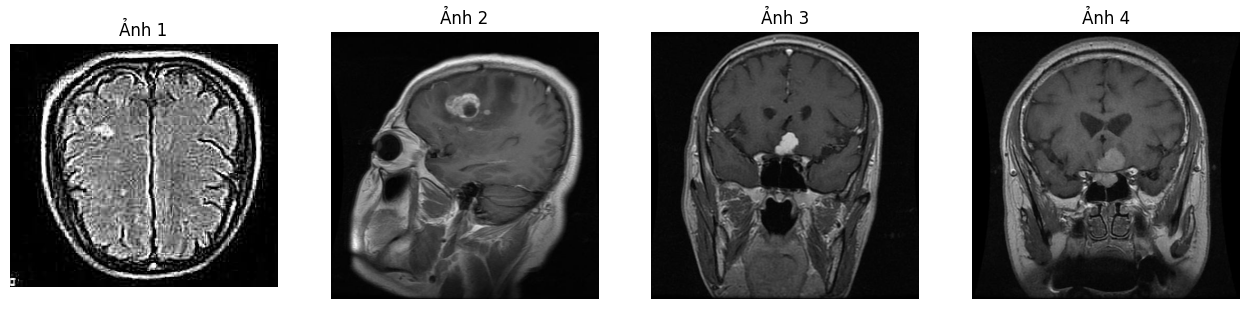

In [11]:
data_dir = r'./Brain Tumor Segmentation Dataset/image'
image_files = []

# Lấy 1 ảnh ngẫu nhiên từ mỗi thư mục con (0, 1, 2, 3)
for folder in ['0', '1', '2', '3']:
    folder_path = os.path.join(data_dir, folder)
    if os.path.exists(folder_path):
        files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        if files:
            random_file = random.choice(files)
            image_files.append(os.path.join(folder_path, random_file))

# Kiểm tra số lượng ảnh đã chọn
print(f"Số lượng ảnh đã chọn: {len(image_files)}")

# Hiển thị các ảnh đã chọn
print("Các ảnh đã chọn:")
showImages(range(len(image_files)), image_files=image_files)

4 ảnh xám:


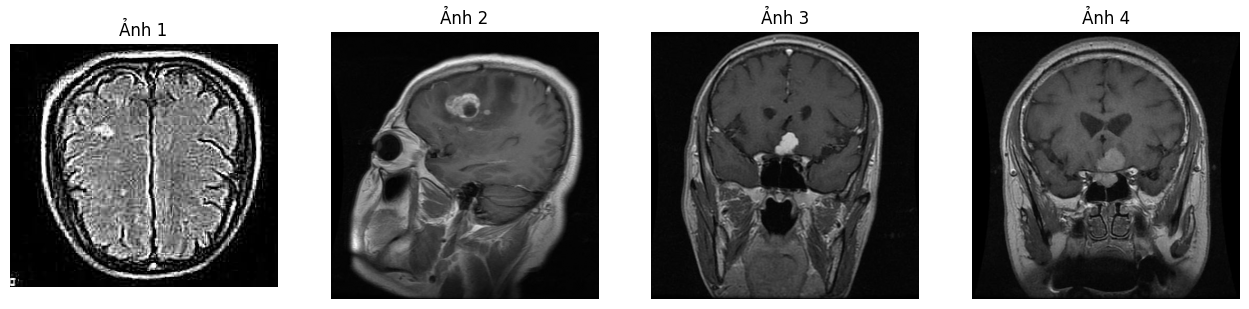

In [12]:
gray_images = []
for idx in range(len(image_files)):
    gray_img = cv2.imread(image_files[idx], cv2.IMREAD_GRAYSCALE)
    gray_images.append(gray_img)

print("4 ảnh xám:")
showImages(range(len(gray_images)), images=gray_images)

4 ảnh xám đã resize:


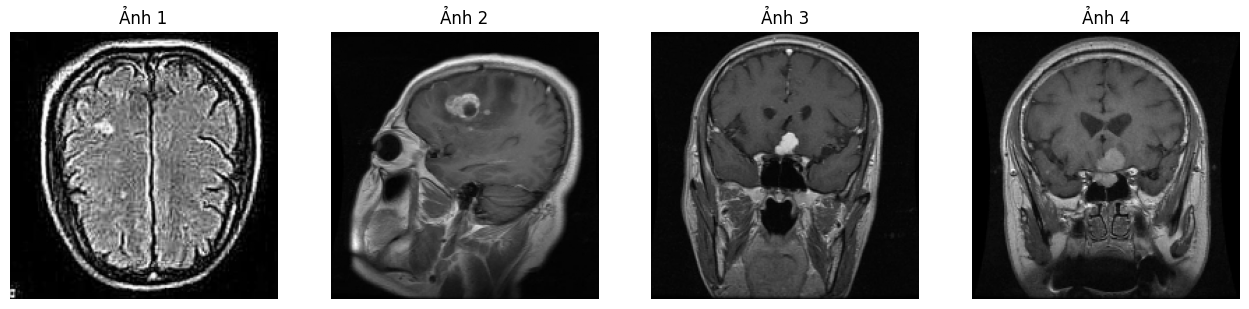

In [13]:
# Resize ảnh về kích thước 192x192
resized_images = []
size = (192, 192)
for img in gray_images:
    resized_img = cv2.resize(img, size, cv2.INTER_AREA)
    resized_images.append(resized_img)

print("4 ảnh xám đã resize:")
showImages(range(len(resized_images)), images=resized_images)

4 ảnh xám đã cân bằng histogram:


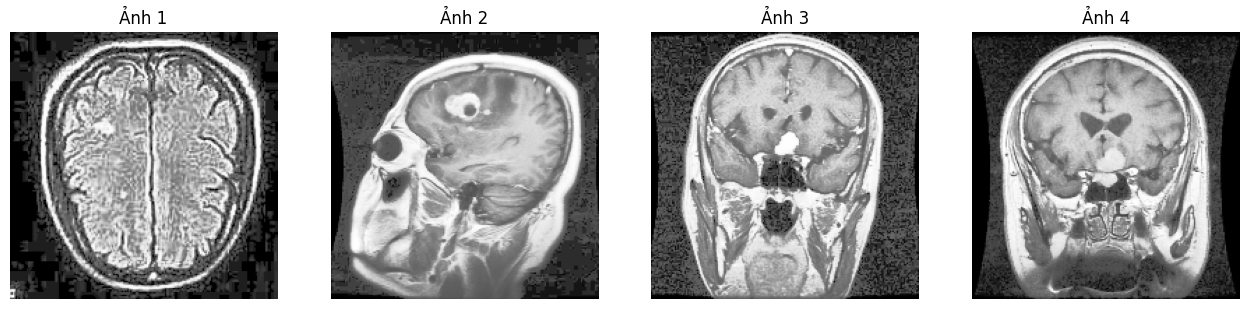

In [14]:
# Cân bằng histogram => Tăng độ tương phản
equalized_images = []
for img in resized_images:
    equalized_img = cv2.equalizeHist(img)  # Cân bằng histogram
    equalized_images.append(equalized_img)

print("4 ảnh xám đã cân bằng histogram:")
showImages(range(len(equalized_images)), images=equalized_images)

4 ảnh xám đã làm mịn:


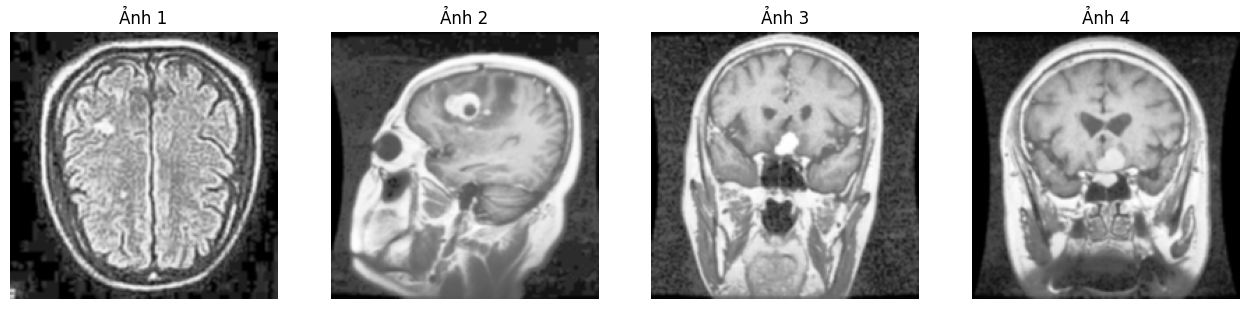

In [15]:
# Làm mịn ảnh
blurred_images = []
for img in equalized_images:
    blurred_img = cv2.GaussianBlur(img, (3, 3), 0)
    blurred_images.append(blurred_img)
print("4 ảnh xám đã làm mịn:")
showImages(range(len(blurred_images)), images=blurred_images)

2. Áp dụng thuật toán DBSCAN


=== Ảnh 1 ===
0.30709037721980387


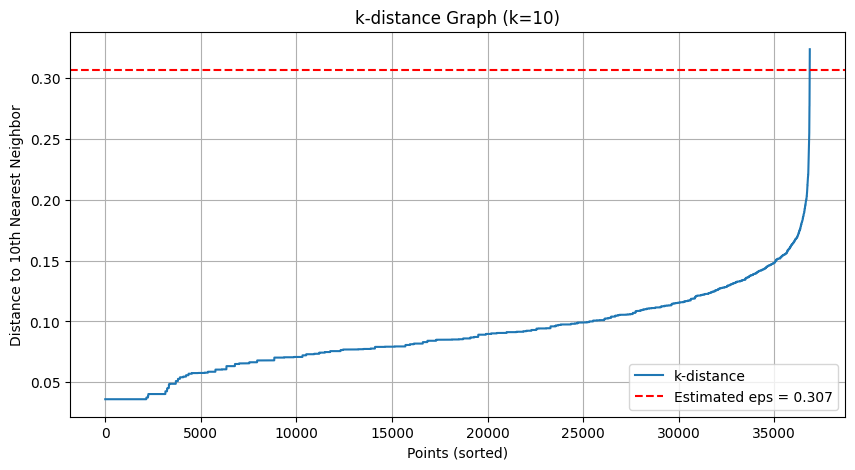

→ eps tối ưu = 0.31, min_samples tối ưu = 200


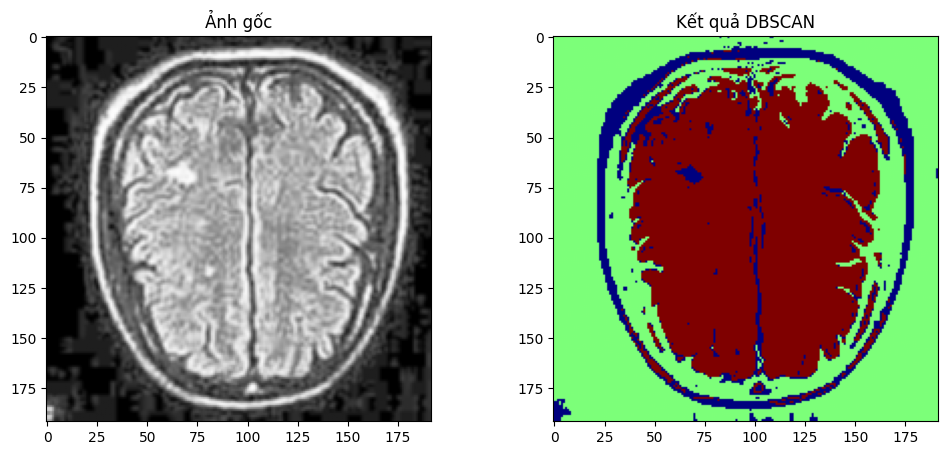


=== Ảnh 2 ===
0.2408796300998023


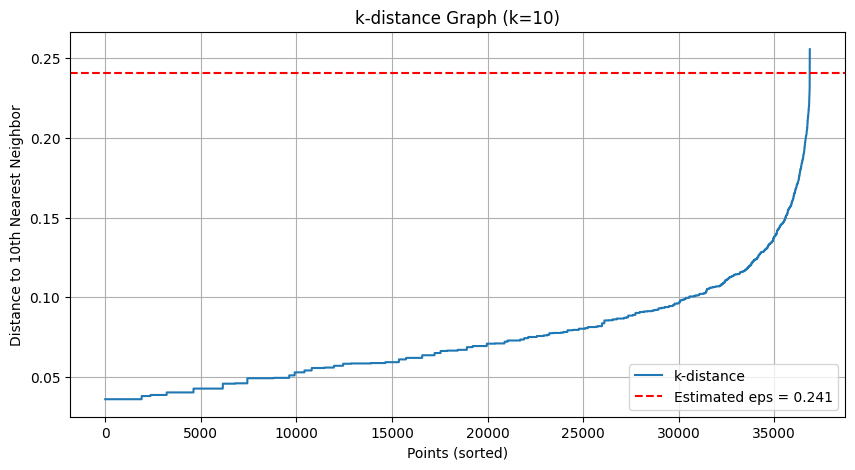

→ eps tối ưu = 0.24, min_samples tối ưu = 220


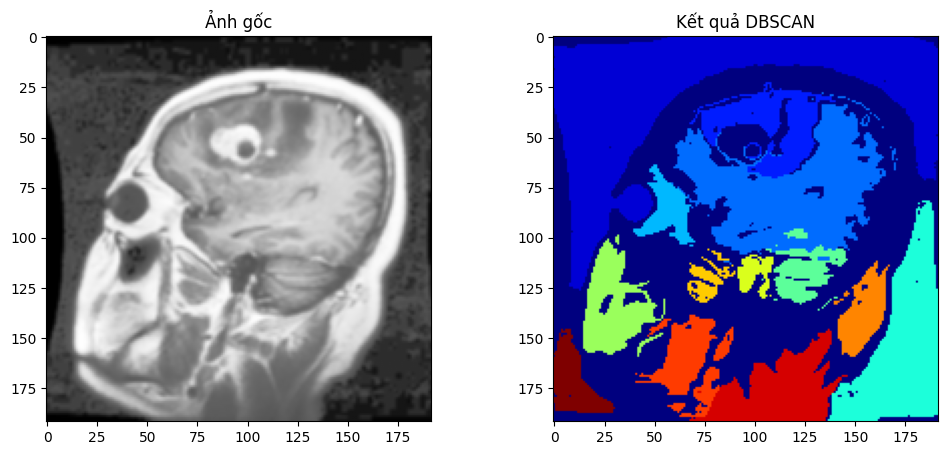


=== Ảnh 3 ===
0.3104510467202525


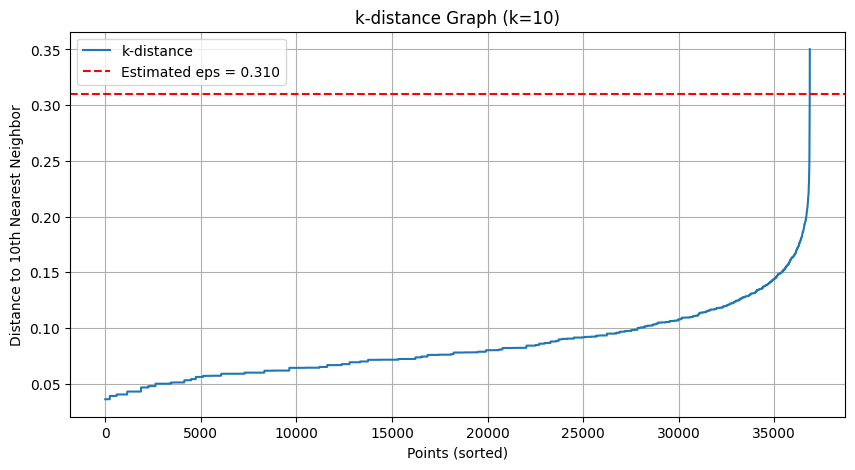

→ eps tối ưu = 0.31, min_samples tối ưu = 240


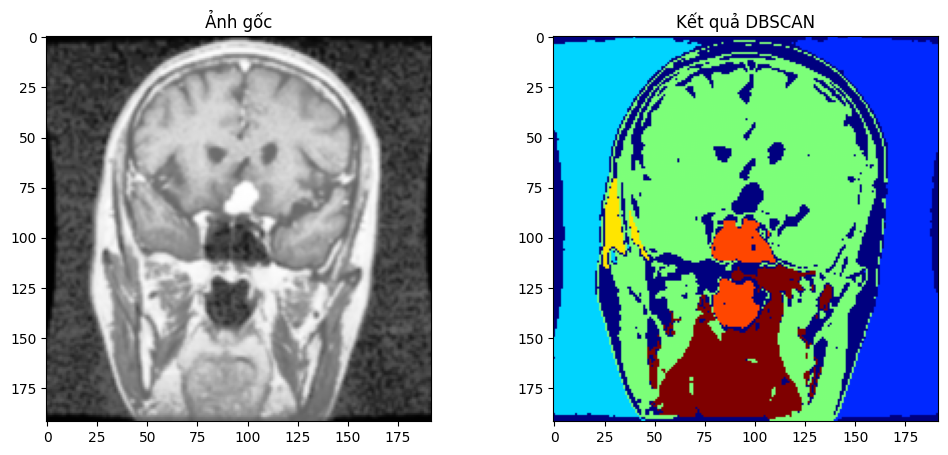


=== Ảnh 4 ===
0.3061449152338735


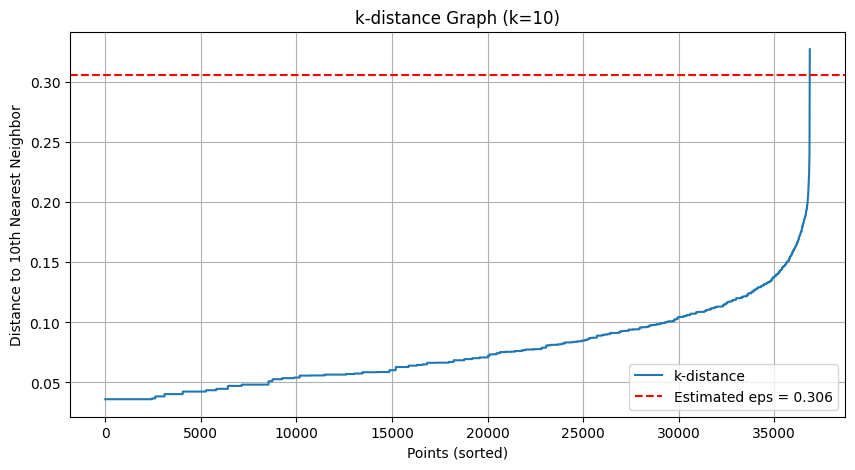

→ eps tối ưu = 0.31, min_samples tối ưu = 290


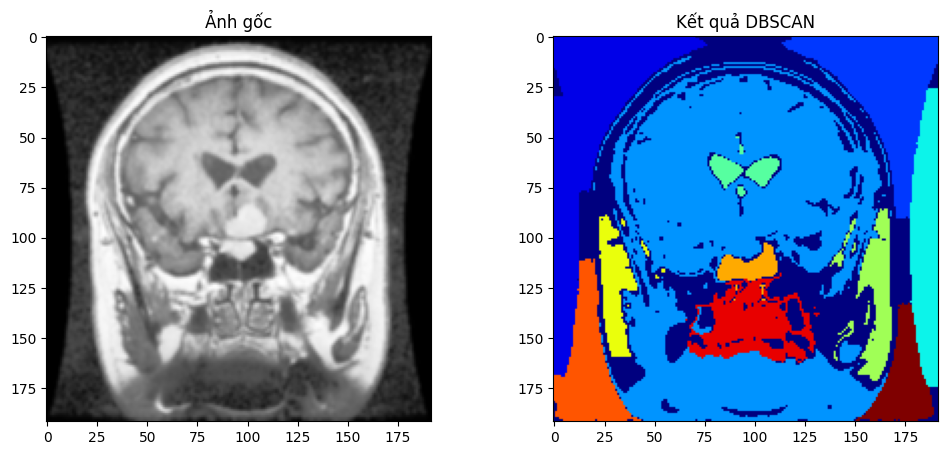

In [16]:
for image in blurred_images:
    h, w = image.shape
    X = np.column_stack((np.indices((h, w)).reshape(2, -1).T, image.flatten()))
    
# Tìm eps tối ưu dựa trên k-distance
def getEps(X_scaled):
    k = 10
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X_scaled)
    distances, _ = neigh.kneighbors(X_scaled)
    distances = np.sort(distances[:, k-1], axis=0)

    kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    knee_eps = kneedle.knee_y

    n_points = len(distances)
    all_coords = np.arange(n_points)
    first_derivative = np.diff(distances)
    second_derivative = np.diff(first_derivative)
    knee_idx = np.argmax(second_derivative) + 1
    knee_eps = distances[knee_idx]
    
    print(knee_eps)

    plt.figure(figsize=(10, 5))
    plt.plot(distances, label='k-distance')
    plt.axhline(y=knee_eps, color='r', linestyle='--', label=f'Estimated eps = {knee_eps:.3f}')
    plt.title(f"k-distance Graph (k={k})")
    plt.xlabel("Points (sorted)")
    plt.ylabel(f"Distance to {k}th Nearest Neighbor")
    plt.legend()
    plt.grid(True)
    plt.show()
    return knee_eps

# Tìm Minpts tối ưu dựa trên Silhouette Score
def find_best_min_samples(X_scaled, eps, min_samples_range):
    best_score = -1
    best_min_samples = None
    silhouette_scores = []

    for min_samples in min_samples_range:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters >= 2:
            score = silhouette_score(X_scaled, labels)
            silhouette_scores.append((min_samples, score))

            if score > best_score:
                best_score = score
                best_min_samples = min_samples

    return best_min_samples, silhouette_scores

final_results = []

for i, img in enumerate(blurred_images):
    print(f"\n=== Ảnh {i+1} ===")
    h, w = img.shape
    X = np.column_stack((np.indices((h, w)).reshape(2, -1).T, img.flatten()))  # (h*w, 3)
    X_scaled = StandardScaler().fit_transform(X)

    # Tìm eps tối ưu
    eps = getEps(X_scaled)

    # Tìm min_samples tối ưu
    min_samples_range = range(10, 300, 10)
    best_min_samples, scores = find_best_min_samples(X_scaled, eps, min_samples_range)
    print(f"→ eps tối ưu = {eps:.2f}, min_samples tối ưu = {best_min_samples}")

    # Áp dụng DBSCAN
    labels = DBSCAN(eps=eps, min_samples=best_min_samples).fit_predict(X_scaled)
    label_img = labels.reshape(h, w)
    final_results.append((img, label_img))

    # Hiển thị kết quả
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Ảnh gốc")
    plt.subplot(1, 2, 2)
    plt.imshow(label_img, cmap='jet')
    plt.title("Kết quả DBSCAN")
    plt.show()